# Overview/goals
This project showcases how *puboracle* can be used to mine PubMed and extract info on geospatial location of research activity, networks of collaborations and related matrics.

This example tracks publications with the key word "connectome" or "connectomics" in the last year and dispays key geospatial data and metrics related to these publications.

In [2]:
import math
from pathlib import Path
import re

from puboracle.writestoredata import getdata,readwritefun
from puboracle.txtprocess import txt2geo
from puboracle.visualization import visfun
from puboracle.metrics import txtmetrics

Submit query and fetch data in an XML format

In [ ]:
save_folder = '/Users/alexandrosgoulas/Data/work-stuff/projects/example_puboracle_connectomics/xmldata/'
query = 'connectomics OR connectome'
days = 365
email = 'arimpos@gmail.com'

getdata.fetch_write_data(
                        query = query,
                        datetype = 'pdat',
                        email = email,
                        days = days,
                        save_folder = save_folder
                        )

Read all the XML files that were downloaded

In [3]:
folder_to_xmls = Path('/Users/alexandrosgoulas/Data/work-stuff/projects/example_puboracle_connectomics/xmldata/')
all_xml_files = readwritefun.get_files_in_folder(folder_to_xmls, 
                                                order = True
                                                )

Read the XML files and extract the desired info specified by the list keys_to_parse

In [4]:
keys_to_parse = [
                 'affiliations'
                ]

pub_data, xml_filenames = readwritefun.read_xml_to_dict(folder_to_xmls, 
                                                        all_xml_files = all_xml_files,
                                                        keys_to_parse = keys_to_parse
                                                        )


Iterating file...: xml_0.xml


Extract affiliations

In [5]:
affiliations = pub_data[keys_to_parse.index('affiliations')]

Remove unwanted elements from affiliations:
i.  email address 
ii. author names or initials in parentheses (can also remove acronyms of location but this is OK)   
iii. the word "and" from the beginning of an affiliation 

In [6]:
affiliations_cleaned = []
for i,affil in enumerate(affiliations):
    affil_split = affil.split(';')
    items_to_re_join = []
    for item in affil_split:
        cleaned = re.sub("[\(\[].*?[\)\]]", "", item)#remove text in parentheses
        cleaned = re.sub("\S*@\S*\s?", "", cleaned).rstrip()#remove email address
        cleaned = cleaned.replace('electronic address:','')# remove 'electronic address:'
        cleaned = cleaned.replace('Electronic address:','')# remove 'Electronic address:'
        cleaned = re.sub("^\sand", "", cleaned)# remove 'and' from the beggining (preceeded by whitespace)
        items_to_re_join.append(cleaned)    
    affiliations_cleaned.append(';'.join(items_to_re_join))    

Remove empty entries

In [7]:
affiliations_cleaned = [affil for affil in affiliations_cleaned if affil]

Get all the unique cleaned affiliations

In [8]:
(all_affiliations_cleaned, 
 unique_affiliations_cleaned, 
 occurences) = txtmetrics.get_unique_strs(affiliations_cleaned,
                                          exclude= ['',' ']
                                          )

Geolocation: extract latitude and longitude from the textual description of the locations in each affiliation

In [9]:
lat,lon,txtforloc = txt2geo.get_lat_lon_from_text_wordwise(
                                                           unique_affiliations_cleaned,
                                                           reverse = False,
                                                           verbose = False 
                                                           )

Remove lat lon nan entries and visualize the rest on a global map

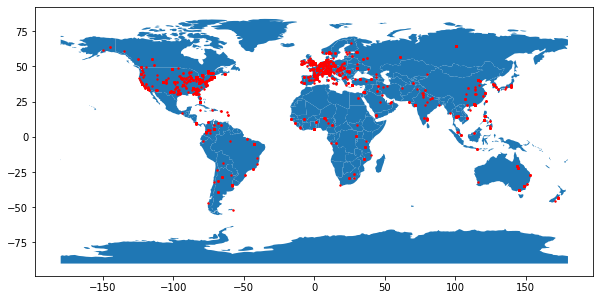

In [10]:
lat = [item for item in lat if not math.isnan(item)]
lon = [item for item in lon if not math.isnan(item)]
visfun.vis_lon_lat(longitude=lon, latitude=lat)

The above map offers an overview of the distribution of the location across the globe where research was conducted 
and resulted in a publication with the keywords "connectome" or "connectomics" in the last year. 

Visualize top 10 of affiliations with the max publications, after the merge of nr of publications between affiliations
that exceed a string similarity threshold

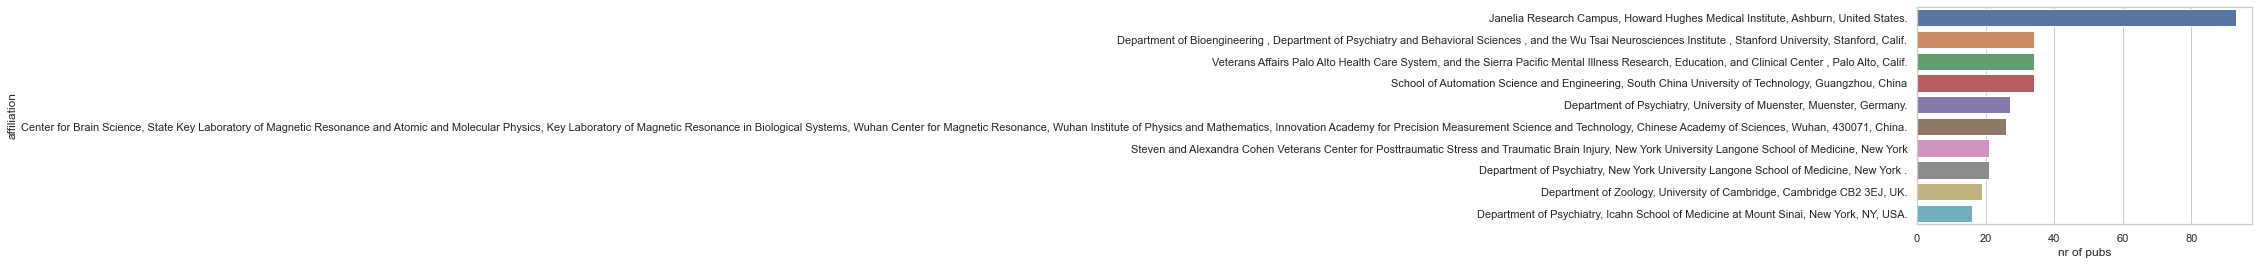

In [11]:
(affiliations_nrpubs_topmerged, 
 _) = txtmetrics.add_by_similarity(occurences, 
                                   topN = 10, 
                                   look_ahead = 500,
                                   threshold = 0.8
                                  )
                                                     
visfun.visualize_counter_selection(affiliations_nrpubs_topmerged)

We can see that there is a large inhomogeneity of publications per affiliation with the 
Janelia Research Campus, Howard Hughes Medical, USA at the top with more than 80 publications